# Learning Spatial Relationships with MISTy


### Import generic packages

In [1]:
import scanpy as sc
import squidpy as sq
import decoupler as dc
import plotnine as p9
import liana as li

### Import helper functions and Pre-defined single view models 

In [2]:
from liana.method import MistyData, genericMistyData, lrMistyData
from liana.method.sp import RandomForestModel, LinearModel, RobustLinearModel

### Load and normalize data

In [3]:
folder    = '/lustre/groups/ml01/workspace/sara.jimenez/spatial_pancreas_data/preprocessed_data/data4downstream/'
adata_imp = sc.read(filename = folder + 'imputed_envi.h5ad')
adata     = sc.read(filename = folder + 'adata_sp_fov_12.h5ad')
adata, adata_imp

(AnnData object with n_obs × n_vars = 5208 × 979
     obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse', 'cell_type', 'leiden'
     var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
     uns: 'cell_type_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'spatial', 'umap'
     obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_fov'
     varm: 'PCs'
     layers: 'c

In [ ]:
adata.layers['counts'] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

### Functional analysis

#### pathway activity

In [4]:
# obtain genesets
progeny = dc.get_progeny(organism='human', top=500)

/home/aih/sara.jimenez/miniconda3/envs/liana/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
Failed to download from `https://omnipathdb.org/`.
Traceback (most recent call last):
  File "/home/aih/sara.jimenez/miniconda3/envs/liana/lib/python3.9/site-packages/urllib3/connectionpool.py", line 715, in urlopen
    httplib_response = self._make_request(
  File "/home/aih/sara.jimenez/miniconda3/envs/liana/lib/python3.9/site-packages/urllib3/connectionpool.py", line 404, in _make_request
    self._validate_conn(conn)
  File "/home/aih/sara.jimenez/miniconda3/envs/liana/lib/python3.9/site-packages/urllib3/connectionpool.py", line 1058, in _validate_conn
    conn.connect()
  File "/home/aih/sara.jimenez/miniconda3/envs/liana/lib/python3.9/site-packages/urllib3/connection.py", line 419, in connect
    self.sock = ssl_wrap_socket(
  File "/home/aih/sara.jimenez/

In [5]:
# use multivariate linear model to estimate activity
dc.run_mlm(
    mat=adata,
    net=progeny,
    source='source',
    target='target',
    weight='weight',
    verbose=True,
    use_raw=False,
)

Running mlm on mat with 5208 samples and 979 targets for 14 sources.


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


In [6]:
# extract progeny activities as an AnnData object
acts_progeny = li.ut.obsm_to_adata(adata, 'mlm_estimate')

In [7]:
acts_progeny.var_names

Index(['Androgen', 'EGFR', 'Estrogen', 'Hypoxia', 'JAK-STAT', 'MAPK', 'NFkB',
       'PI3K', 'TGFb', 'TNFa', 'Trail', 'VEGF', 'WNT', 'p53'],
      dtype='object')

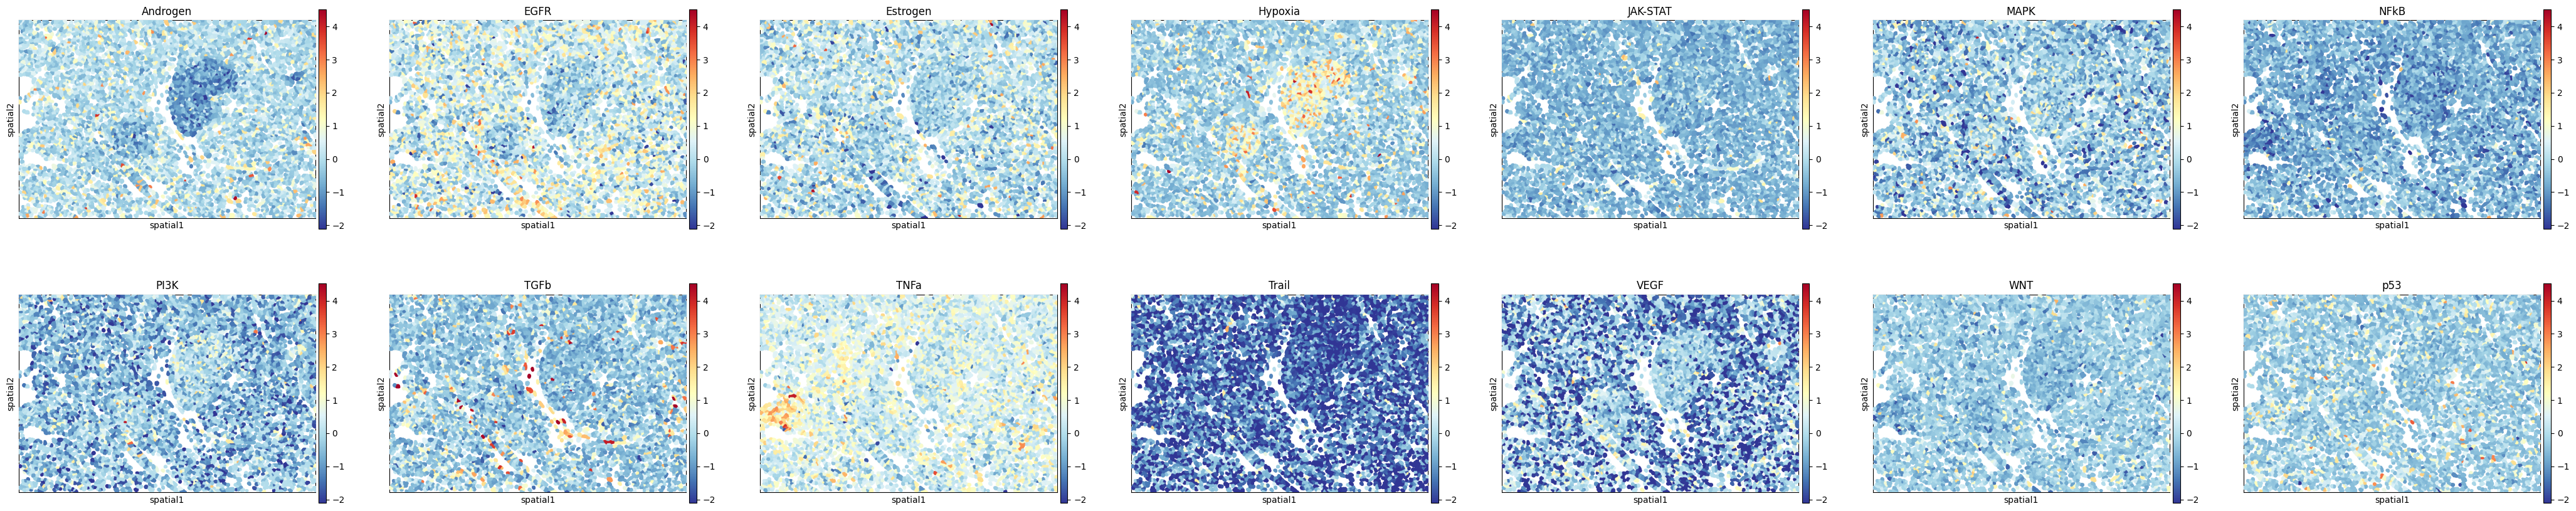

In [8]:
# Check how the pathway activities look like
sq.pl.spatial_segment(acts_progeny,color=['Androgen', 'EGFR', 'Estrogen', 'Hypoxia', 'JAK-STAT', 'MAPK', 'NFkB',
       'PI3K', 'TGFb', 'TNFa', 'Trail', 'VEGF', 'WNT', 'p53'],ncols=7,
                      library_key='fov', seg_cell_id='cell_ID',cmap='Greys', img=False)

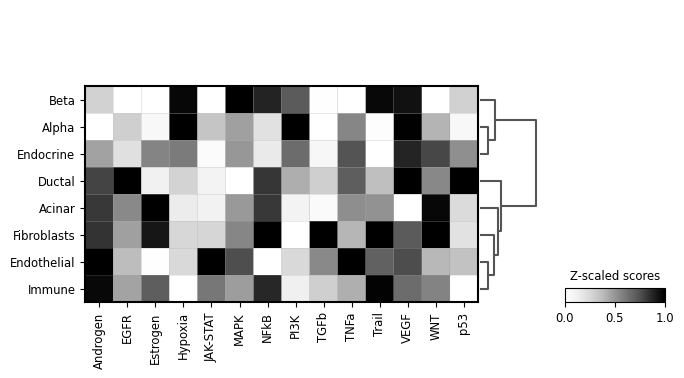

In [8]:
sc.pl.matrixplot(acts_progeny, var_names=acts_progeny.var_names, groupby='cell_type', dendrogram=True, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='Greys')

#### TF activity inference

In [9]:
net = dc.get_collectri(organism='human', split_complexes=False)
net

source          target  weight  \
0         MYC            TERT       1   
1        SPI1           BGLAP       1   
2       SMAD3             JUN       1   
3       SMAD4             JUN       1   
4      STAT5A             IL2       1   
...       ...             ...     ...   
43173    NFKB  hsa-miR-143-3p       1   
43174     AP1     hsa-miR-206       1   
43175    NFKB   hsa-miR-21-5p       1   
43176    NFKB  hsa-miR-224-5p       1   
43177     AP1     hsa-miR-144       1   

                                                    PMID  
0      10022128;10491298;10606235;10637317;10723141;1...  
1                                               10022617  
2                                      10022869;12374795  
3                                      10022869;12374795  
4      10022878;11435608;17182565;17911616;22854263;2...  
...                                                  ...  
43173                                           19472311  
43174                                           19721712  
43175                                  20813833;22387281  
43176                                  23474441;23988648  
43177                                           23546882  

[43178 rows x 4 columns]

In [10]:
dc.run_ulm(
    mat=adata,
    net=net,
    source='source',
    target='target',
    weight='weight',
    verbose=True,
    use_raw=False
)

Running ulm on mat with 5208 samples and 979 targets for 469 sources.


100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


In [11]:
acts = dc.get_acts(adata, obsm_key='ulm_estimate')

In [12]:
acts.var_names

Index(['ABL1', 'AHR', 'AIRE', 'AP1', 'APEX1', 'AR', 'ARID1A', 'ARID4B', 'ARNT',
       'ARX',
       ...
       'ZKSCAN7', 'ZMYND8', 'ZNF148', 'ZNF300', 'ZNF354C', 'ZNF362', 'ZNF382',
       'ZNF384', 'ZNF699', 'ZNF91'],
      dtype='object', length=469)

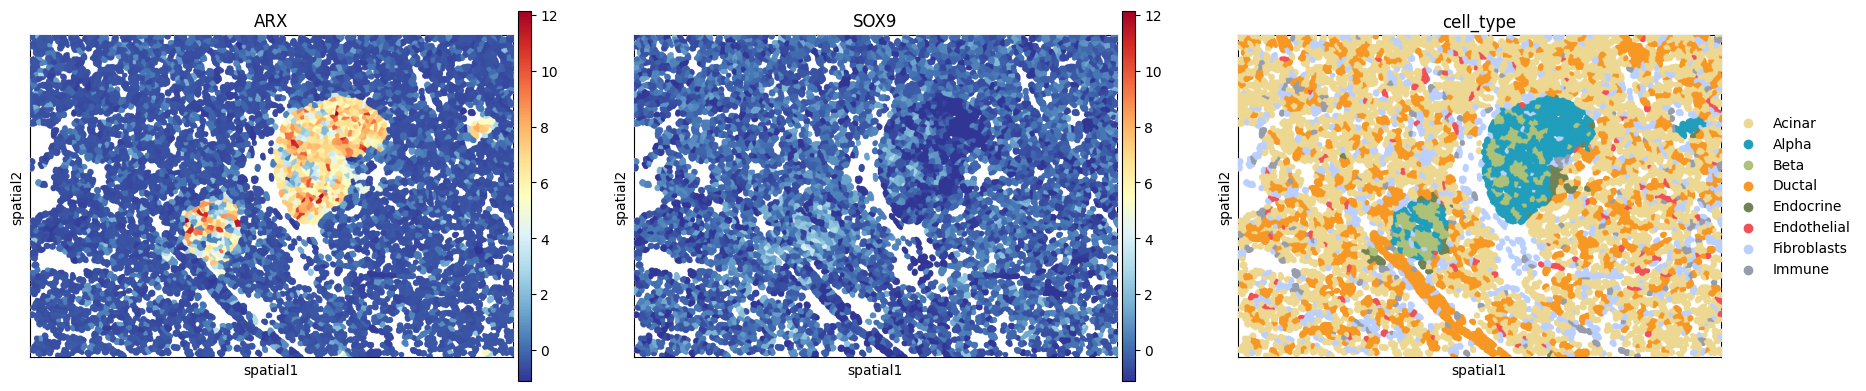

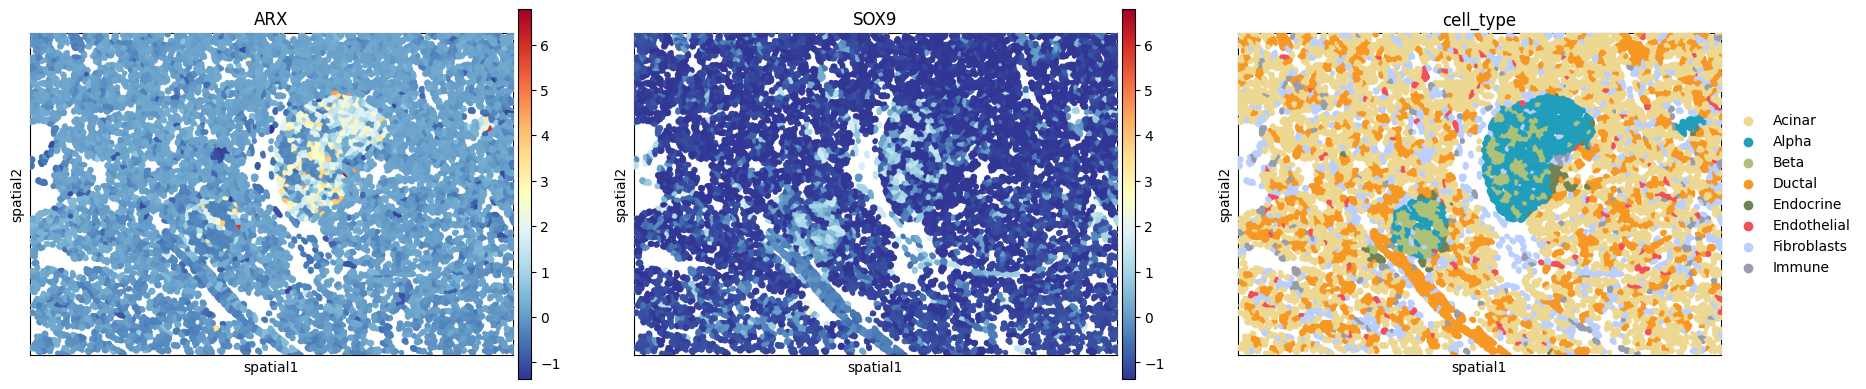

In [18]:
# Check how the TF activities look like
sq.pl.spatial_segment(acts,color=['ARX', 'SOX9', 'cell_type'],ncols=3,
                      library_key='fov', seg_cell_id='cell_ID',cmap='RdYlBu_r', img=False)

sq.pl.spatial_segment(acts_imp,color=['ARX', 'SOX9', 'cell_type'],ncols=3,
                      library_key='fov', seg_cell_id='cell_ID',cmap='RdYlBu_r', img=False)

In [13]:
df = dc.rank_sources_groups(acts, groupby='cell_type', reference='rest', method='t-test_overestim_var')
df

group reference   names  statistic  meanchange          pvals  \
0     Acinar      rest  ZNF362  41.407565    1.448477  2.520426e-310   
1     Acinar      rest   NR0B2  37.951422    1.372589  4.782399e-262   
2     Acinar      rest    KLF5  35.772583    0.902004  4.882718e-246   
3     Acinar      rest    PAX3  29.148664    0.661713  4.539920e-171   
4     Acinar      rest   NR3C1  26.996154    0.638055  7.529698e-148   
...      ...       ...     ...        ...         ...            ...   
3747  Immune      rest    HSF1  -6.227386   -0.824027   2.014587e-09   
3748  Immune      rest   GATA1  -6.332014   -0.510760   8.982788e-10   
3749  Immune      rest   NCOA1  -6.350303   -0.459244   8.454490e-10   
3750  Immune      rest     ID1  -7.943784   -0.725738   4.438062e-14   
3751  Immune      rest   HNF1A  -9.281628   -1.286457   5.290466e-18   

          pvals_adj  
0     1.182080e-307  
1     7.476484e-260  
2     4.579989e-244  
3     1.252484e-169  
4     1.177143e-146  
...             ...  
3747   4.294733e-08  
3748   2.217330e-08  
3749   2.202864e-08  
3750   2.312724e-12  
3751   8.270762e-16  

[3752 rows x 7 columns]

In [14]:
n_markers = 5
source_markers = df.groupby('group').head(n_markers).groupby('group')['names'].apply(lambda x: list(x)).to_dict()
source_markers

{'Acinar': ['ZNF362', 'NR0B2', 'KLF5', 'PAX3', 'NR3C1'],
 'Alpha': ['PAX2', 'FOXA1', 'FOXA2', 'ARX', 'ONECUT1'],
 'Beta': ['PLAGL1', 'CREBZF', 'PREB', 'MXD1', 'NR1H2'],
 'Ductal': ['KLF8', 'SP4', 'AR', 'SMARCA5', 'GTF2I'],
 'Endocrine': ['FOXA2', 'FOXA1', 'MAFA', 'SMARCA1', 'PAX2'],
 'Endothelial': ['ERG', 'CIITA', 'HIVEP2', 'RFX5', 'RFXAP'],
 'Fibroblasts': ['SKIL', 'JDP2', 'SMAD3', 'APEX1', 'ZEB2'],
 'Immune': ['PITX3', 'NFYB', 'RFXAP', 'RFXANK', 'RFX5']}

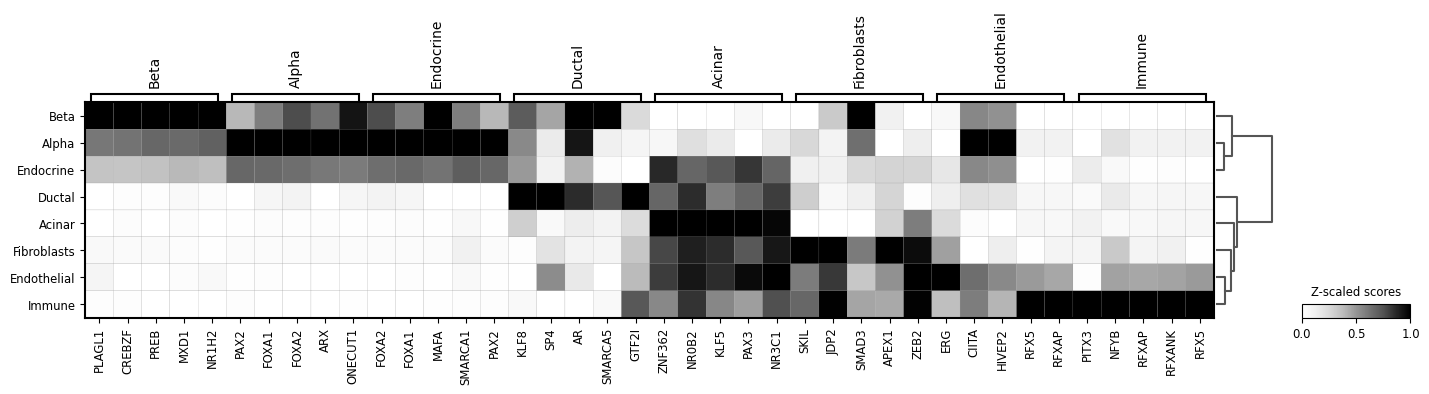

In [15]:
sc.pl.matrixplot(acts, source_markers, 'cell_type', dendrogram=True, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='Greys')

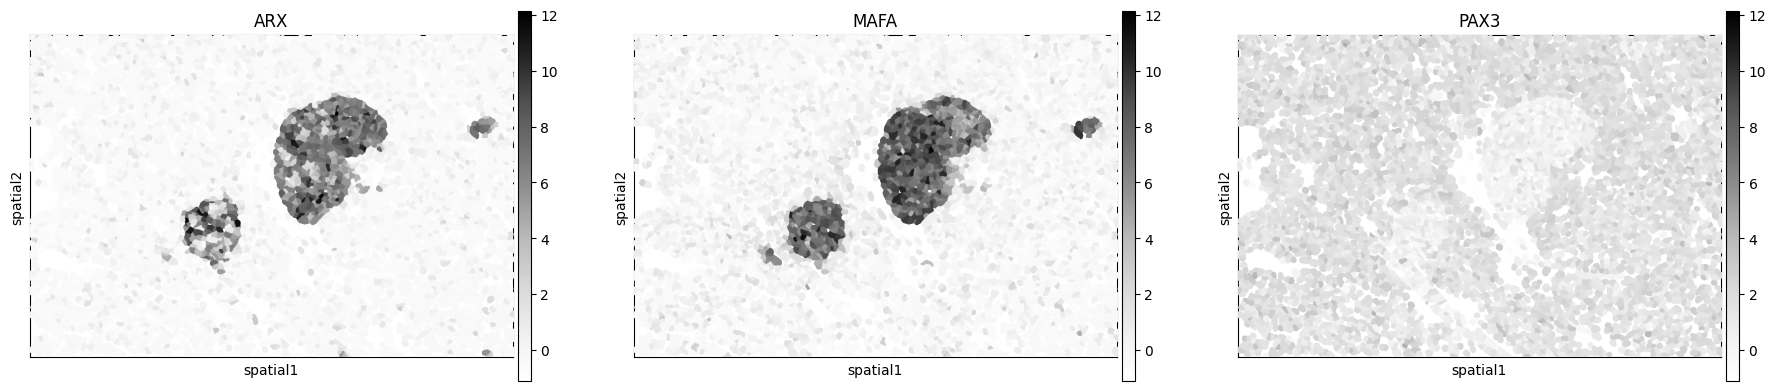

In [16]:
sq.pl.spatial_segment(acts,color=['ARX','MAFA', 'PAX3'],ncols=3,
                      library_key='fov', seg_cell_id='cell_ID',cmap='Greys', img=False)